# Feature Engineering

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import auc, confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, precision_recall_curve, classification_report
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import SimpleImputer, IterativeImputer, MissingIndicator

import ast
from functions import report
%matplotlib inline

## Preliminary Steps
Let's start by loading the data. 

In [2]:
data = pd.read_csv("data/raw_data.csv", index_col=0)
target = pd.read_csv('data/target.csv', index_col=0)
data['fraud'] = target['fraud']

#### Digging for extra info:

Some columns need little or no manipulation to yield useful information. We looked at those in the EDA notebook. Now we are going to try to extract any pertinent information from the remaining columns. Many of these will be text columns. 

In [3]:
data[['country', 'currency', 'ticket_groups', 'venue_country', 'venue_state']].head()

,country,currency,ticket_groups,venue_country,venue_state
0,US,USD,"[{'event_id': 527017, 'cost': 25.0, 'availabil...",US,FL
1,US,USD,"[{'event_id': 786878, 'cost': 35.0, 'availabil...",US,SC
2,US,USD,"[{'event_id': 787337, 'cost': 93.51, 'availabi...",US,CA
3,IE,EUR,"[{'event_id': 885645, 'cost': 25.0, 'availabil...",NaN,NaN
4,US,USD,"[{'event_id': 1114349, 'cost': 150.0, 'availab...",US,MA


#### We're also interested in several columns that are excluded from the display above. 
(You may recall from either the README discussion, or the EDA notebook, that we are using real data from an online ticket vendor. As such, I am taking steps to hide all identifiable information.)

The additional columns we'll use in this notebook are: 

* Name (of event)
* Description (of event)
* Email Domain (of event creator)
* Organization Name 
* Organization Description
* Payee Name 
* Past Payouts
* Venue Name
* Venue Address

To offer a better idea of the information contained in those columns, I have created a few fake sample entries: 

| Column Name     |                Column Description                  | dtype  |   Sample Entry               |
|:---------------:|:--------------------------------------------------:|:------:|:----------------------------:|
| name            | Name of the event                                  | string | ABC's Annual Fundraiser      |
| description     | Description of the event                           | string |  `<h3><span class="subcategory"><strong> Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat. </strong><strong></strong></span></h3> <h3><font face="arial,helvetica,sans-serif" size="3">W Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua. Ut enim ad minim veniam, quis nostrud exercitation ullamco laboris nisi ut aliquip ex ea commodo consequat..</font></h3>`  |
| email_domain    | Email domain of the event creator                  | string | Ex: gmail.com; ed.ac.uk; ABC.org |
| org_name        | Name of the organization hosting the event         | string |       ABC                    |
| org_desc        | Description of the organization hosting the event  | string | `<p>ABC is a sample organization name</p>`|
| payee_name      | Named recipient of ticket revenue                  | string | Ex: ABC; Joe Smith           |
| past_payouts    | Details of past ticket purchase to event creator   | string |`[{'name': 'ABC', 'created': '2010-10-01 01:10:09', 'country': 'OZ', 'amount': 34389.38, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-02-02 01:12:10', 'country': 'OZ', 'amount': 764.93, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 17405.26, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 2224.16, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}]`|
| venue_name      | Name of event venue                                | string |     ABC Building      |
| venue_address   | Address of event venue                             | string | 123 Yellow Brick Road |
| venue_latitude  | Latitude of event venue                            | float  |      -45.0123         |
| venue_longitude | Longitude of event venue                           | float  |      -123.456         |





#### Before we move on from preliminary steps, remember to consider : 
### What information are we looking for? 
The quick answer is: anything that will help us distinguish fraud from legitimate activity. 

The quick answer, however, doesn't particularly narrow the field. We can't evaluate the relationship between a feature and fraud until we define the feature. 

It is possible to make a feature by counting the number of times the character 'a' occurs in the event description, but we have no reason to believe that this would be a good indicator of fraud. 

There are infinite possibilities for engineered features, so to some degree, we have to rely on our own judgement &mdash; which, we hope, is a product of business savvy, industry knowledge, and logic. 

Let's brainstorm: 

### What would characteristics would jump out to you, as either MORE or LESS likely to occur in cases of fraud?

My initial ideas (recalling the information we have to work with):

* We saw in the EDA notebook that the median value for 'name_length' and 'body_length' is higher for non-fraud entries than for fraud entries. Could it be useful to examine the character count for other fields, too? Ex: **'org_name', 'org_desc', 'venue_name'**
* Adding formatting is often more tedious than writing a description. I wonder if the character count of HTML formatting within the **'description'** field would be lower in instances of fraud. 
* I would be suprised to find many instances of fraud among entries that have a large number of **past_payouts**, as this would suggest previous fraud has repeatedly gone unreported OR a legitimate account has suddenly added a fraudulent event. While neither is unheard of, I wouldn't expect it to be frequent. 


It is also worth noting that we don't have to have a prediction for whether a specific characteristic makes fraud more likely or less likely, as long as it seems reasonable that the characteristic might have some correspondence to instances of fraud. 

## Process existing columns into new features
We don't need to generate a full list above. New ideas will inevitably come up as we learn more about the columns.

**'ticket_groups'** & **'past_payouts'** are two of the obvious examples of columns that require processing, but contain useful information. Both contain string representations of a list of dictionaries. 
 
### 1 — 'ticket_groups' 

Sample Ticket Group entries : 

* `[{'event_id': 4848389, 'cost': 45.0, 'availability': 1, 'quantity_total': 80},
  {'event_id': 4848389, 'cost': 20.0, 'availability': 1, 'quantity_total': 50}, 
  {'event_id': 4848389, 'cost': 0.0, 'availability': 1, 'quantity_total': 6}]`


* `[]`
  
  
* `[{'event_id': 4848389, 'cost': 45.0, 'availability': 1, 'quantity_total': 80}]`

Each entry, though stored as a string, represents a list of dictionaries. Each dictionary contains information about tickets for an event, with 4 keys: event_id, cost, availability, quantity_total. By examining a few examples, I found that all dictionaries within a single list share an **event ID**, while the **cost** and **quantity total** vary. This suggests that events often have **'tiers'** of tickets (i.e. VIP tickets or 'early bird' tickets), each of which are represented separately by one dictionary. 

With the information in the dictionary, we can calculate the number of tiers, the average ticket price, the potential revenue (amount earned if every ticket is sold), and several other figures. 
#### Write a function that extracts relevant information from this string. 

In [4]:
def ticket_groups(df): 
    
    tg_col = df['ticket_groups']
    num_tiers = []
    num_tickets = []
    average_price = []
    min_price = []
    max_price = []
    sum_ticket = []
    
    for row in tg_col:
        row = ast.literal_eval(row)
        num_tiers.append(len(row))
        quant = []
        price = []
        for dct in row:
            quant.append(dct['quantity_total'])
            price.append(dct['cost'])
        arr = np.array([quant, price])
        if arr[0].sum() != 0:
            average_price.append(np.round((arr[0] * arr[1]).sum()/arr[0].sum(), 2))
            num_tickets.append(int(arr[0].sum()))
            min_price.append(arr[1].min())
            max_price.append(arr[1].max())
            sum_ticket.append((arr[0] * arr[1]).sum())
        else: 
            average_price.append(0)
            num_tickets.append(0)
            min_price.append(0)
            max_price.append(0)
            sum_ticket.append(0)
    df["num_tiers"] = num_tiers
    df["tickets_available"] = num_tickets
    df["average_ticket_price"] = average_price
    df['min_price'] = min_price
    df['max_price'] = max_price
    df['potential_revenue'] = sum_ticket

In [5]:
ticket_groups(data)

In [6]:
data[['num_tiers', 'tickets_available', 'average_ticket_price', 'min_price', 'max_price', 'potential_revenue']].head()

,num_tiers,tickets_available,average_ticket_price,min_price,max_price,potential_revenue
0,3,920,39.13,25.00,550.00,36000.00
1,2,100,35.00,35.00,35.00,3500.00
2,1,48,93.51,93.51,93.51,4488.48
3,6,30000,13.67,5.00,25.00,410000.00
4,8,264,108.32,36.00,200.00,28596.00


In [7]:
report(['num_tiers', 'tickets_available', 'average_ticket_price', 'min_price', 'max_price','potential_revenue'], data).T

,name,Number of Unique Values,Number of NaN,Max,Min,Mode,Frequency of Mode
0,num_tiers,55,0,116,0,1,44.46%
1,tickets_available,1168,0,30500000,0,100,6.97%
2,average_ticket_price,4655,0,22727.3,-0.08,10,4.17%
3,min_price,1360,0,15989.8,-1.16,0,22.64%
4,max_price,1728,0,100000,0,10,5.97%
5,potential_revenue,6595,0,7.5e+09,-8,0,3.48%


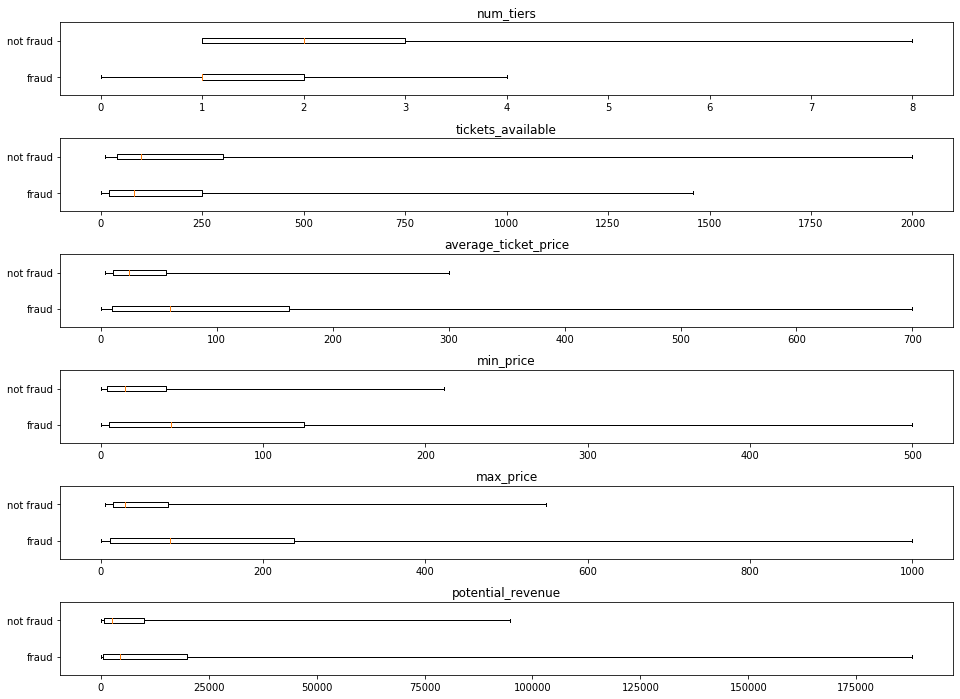

In [8]:
TG_cols = ['num_tiers', 'tickets_available', 'average_ticket_price', 'min_price', 'max_price', 'potential_revenue']
fig, axs = plt.subplots(6,1, figsize =(16,12))
for idx, ax in enumerate(axs.flatten()):    
    ax.boxplot([data[data.fraud == True][TG_cols[idx]], data[data.fraud == False][TG_cols[idx]]], 
               labels=['fraud', 'not fraud'], flierprops=dict(marker='.', markersize=2, alpha=.5), vert=False,
               whis=[5, 95], showfliers=False)
    ax.set_title(TG_cols[idx])
plt.subplots_adjust(hspace = 0.6)

### 2 — 'previous_payouts' 

As with the previous column, this feature contains lists of dictionaries, formatted as strings. Each dictionary represents a payout of ticket sales revenue from the ticket vendor to the event 'host'. Many entries 

`[{'name': 'ABC', 'created': '2010-10-01 01:10:09', 'country': 'OZ', 'amount': 34389.38, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-02-02 01:12:10', 'country': 'OZ', 'amount': 764.93, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 17405.26, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}, {'name': 'ABC', 'created': '2011-03-15 01:30:42', 'country': 'OZ', 'amount': 2224.16, 'state': 'KS', 'address': '123 Yellow Brick Road', 'uid': 1234567, 'event': 9999999, 'zip_code': '98383'}]`

In [13]:
def past_payouts(df):
    pp_col_value = df.past_payouts
    avg_payouts = []
    num_payouts = []
    
    for row in pp_col_value:
        row = ast.literal_eval(row)
        num_payouts.append(len(row))

        if len(row) > 0:
            amount = 0
            for dct in row:
                
                amount += dct['amount']
            avg_payouts.append(np.round(amount/len(row), 2))

        else:
            avg_payouts.append(0)
    df["avg_previous_payouts"] = avg_payouts
    df["num_previous_payouts"] = num_payouts

In [14]:
past_payouts(data)

In [15]:
data[["avg_previous_payouts", "num_previous_payouts"]].head()

,avg_previous_payouts,num_previous_payouts
0,0.00,0
1,16394.36,49
2,1508.40,36
3,208.78,21
4,263.57,49


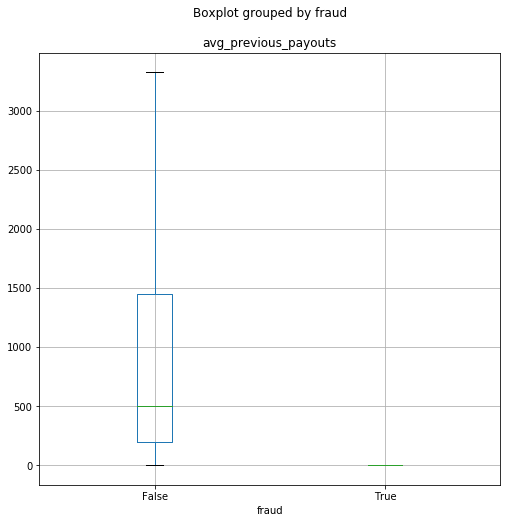

In [17]:
data.boxplot(column=['avg_previous_payouts'], by='fraud', figsize=(8,8), showfliers=False);

### 3 — HTML character count:  
Do descriptions of fraudulent events contain more or less HTML formatting? 

Both fields 'description' and 'org_desc' are text fields with HTML formatting. Our EDA suggested that the 'body_length' field (i.e. the number of characters in 'description') may be a useful indicator. 

From viewing a few examples, it is evident that the description text, and thus the character count, includes HTML tags and entities. We can look at the character count of HTML formatting to see if it might be a useful indicator. 

In [18]:
def scrub_HTML(text):
    punc_entities = ['$quot', '$amp', '$lt', '$lsquo' , '$rsquo', '$ldquo', '$rdquo' , '$sbquo', '$dquo', '$prime', '$dblprime', '$nbsp',
                     '$hyphen', '$ndash', '$mdash', '$nspace', '$mspace', '$thinsp', '$brvbar', '$bull', '$tri', '$hellip', '$circ', '$uml', 
                     '$tilde', '$lsaquo', '$rsaquo', '$laquo', '$raquo', '$oline', '$iquest', '$iexcl', '$intbang']
    # remove html tags & punctuation entities
    text=re.sub("(<.*?>)","",text)
    for x in punc_entities:
        text = re.sub(x, "", text)

    #remove whitespace
    text=text.strip()
    return text

In [19]:
data.description.fillna('', inplace = True)
data['HTML_chars'] = data['description'].apply(lambda x: len(x) - len(scrub_HTML(x)))

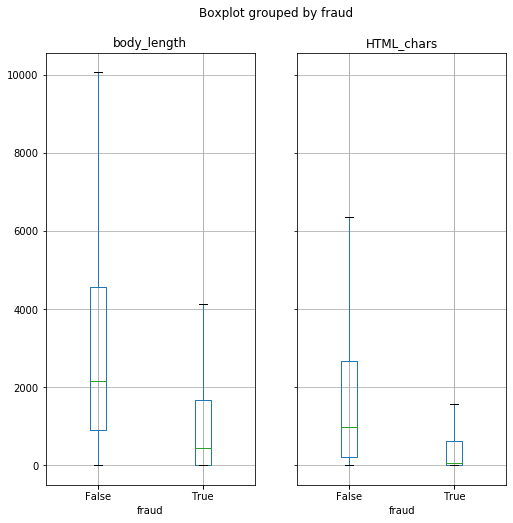

In [21]:
data.boxplot(column=['body_length', 'HTML_chars'], by='fraud', figsize=(8,8), showfliers=False);

### 4 — Categorize Email Suffixes

In [22]:
data['email_suffix'] = data.email_domain.str.strip().str.lower().str.extract(r'([^.]+$)')

In [23]:
top10_nf = list(data[data.fraud == False].email_suffix.value_counts().index[:10])
top10_fr = list(data[data.fraud == True].email_suffix.value_counts().index[:10])
print('Most common email suffixes for fraud: ','\n', top10_fr,'\n')
print('Most common email suffixes for non-fraud: ','\n', top10_nf)

Most common email suffixes for fraud:  
 ['com', 'uk', 'fr', 'net', 'ca', 'de', 'vn', 'org', 'biz', 'pw'] 

Most common email suffixes for non-fraud:  
 ['com', 'org', 'uk', 'au', 'ca', 'net', 'edu', 'ly', 'us', 'nz']


In [24]:
top9 = list(data.email_suffix.value_counts().index[:9])
top9

['com', 'org', 'uk', 'au', 'net', 'ca', 'edu', 'fr', 'ly']

In [25]:
email_suffix_list = list(data.email_suffix.value_counts().index)
email_suffix_dict = {}
for idx in range(len(email_suffix_list)):
    if email_suffix_list[idx] in top9:
        email_suffix_dict[email_suffix_list[idx]] = idx
    else:
        email_suffix_dict[email_suffix_list[idx]] = 9

In [26]:
data['email_suffix_code'] = data.copy().email_suffix.apply(lambda x: email_suffix_dict[x])

In [27]:
email_suffix_not = data[data.fraud == False].email_suffix_code.value_counts().reindex(range(10))
email_suffix_fraud = data[data.fraud == True].email_suffix_code.value_counts().reindex(range(10))

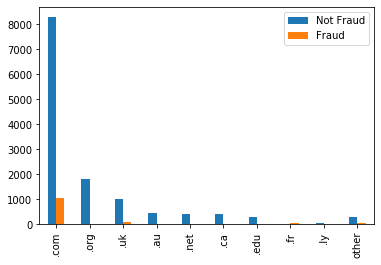

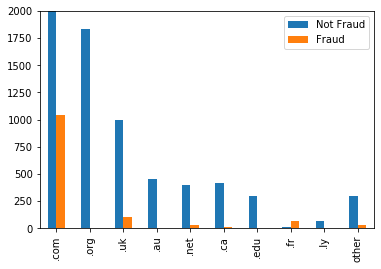

In [28]:
email_NF_count = list(email_suffix_not.values.astype(int))
email_fraud_count = list(email_suffix_fraud.fillna(0).values.astype(int))
index = ['.com', '.org', '.uk', '.au', '.net', '.ca', '.edu', '.fr', '.ly', 'other']
email_df = pd.DataFrame({'Not Fraud': email_NF_count,
                         'Fraud': email_fraud_count}, index = index)

email_df.plot.bar(rot=90)
email_df.plot.bar(rot=90, ylim=[0,2000])
plt.show()

### 5 — Does 'country' match 'venue_country' ?

In [29]:
data['country_match'] = data.country == data.venue_country

In [30]:
NF_matches = [data[(data.fraud == False)&(data.country_match==True)].country_match.count(), data[(data.fraud == False)&(data.country_match==False)].country_match.count()]
fraud_matches = [data[(data.fraud == True)&(data.country_match==True)].country_match.count(), data[(data.fraud == True)&(data.country_match==False)].country_match.count()]

print(NF_matches, fraud_matches)

[10968, 2076] [680, 613]


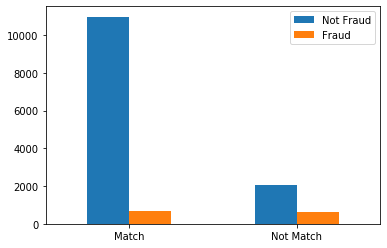

In [31]:
xindex = ['Match', 'Not Match']
xdf = pd.DataFrame({'Not Fraud': NF_matches,
                         'Fraud': fraud_matches}, index = xindex)

xdf.plot.bar(rot=0);

### 6 — Length of Organization Description ('org_desc') 

In [32]:
### Create column for the length of entry in the organization description (org_desc) field. 
data['org_desc_len'] = data.org_desc.fillna('').str.len()

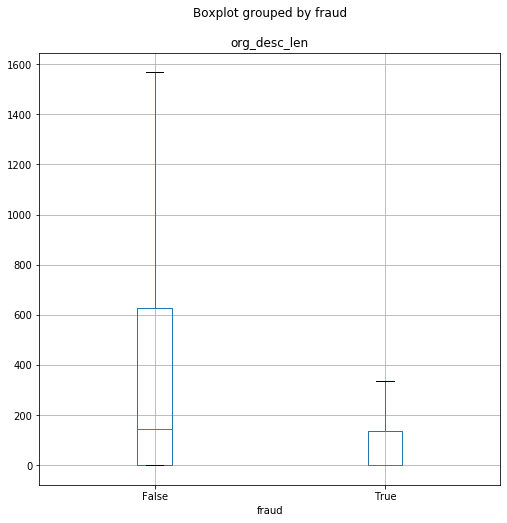

In [33]:
data.boxplot(column=['org_desc_len'], by='fraud', figsize=(8,8), showfliers=False);

### 7 — Length of Venue Name 

In [34]:
### Create column for the length of entry in the venue_name field. 
data['venue_name_len'] = data['venue_name'].fillna('').str.len()

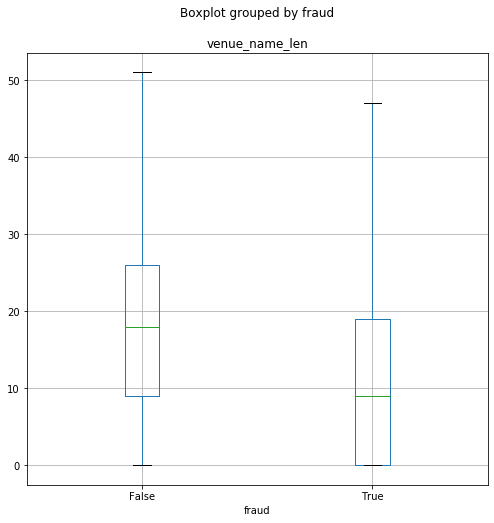

In [35]:
data.boxplot(column=['venue_name_len'], by='fraud', figsize=(8,8), showfliers=False);

### 8 — Length of Organization Name ('org_desc') 

In [36]:
data['org_name_len'] = data['org_name'].fillna('').str.len()

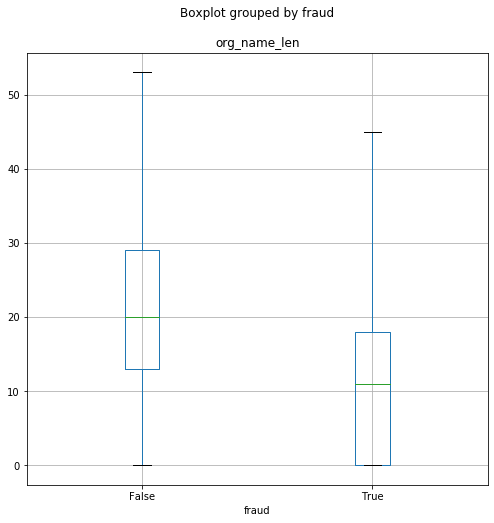

In [37]:
data.boxplot(column=['org_name_len'], by='fraud', figsize=(8,8), showfliers=False);

### 9 — Length of Payee Name ('payee_name') 

In [38]:
print(data[data.fraud == False].payee_name.str.len().mean())
print(data[data.fraud == True].payee_name.str.len().mean())

21.38703527168732
14.733333333333333


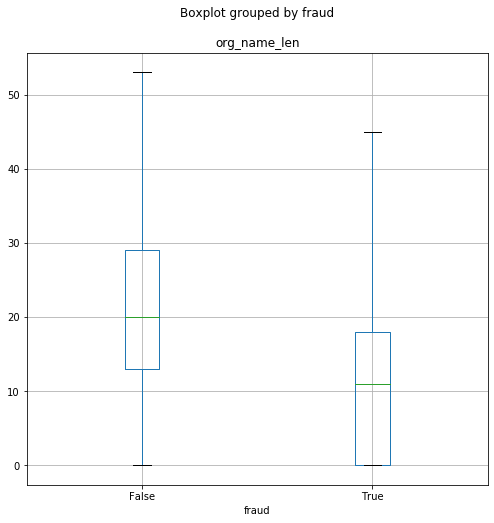

In [39]:
data['org_name_len'] = data['org_name'].fillna('').str.len()
data.boxplot(column=['org_name_len'], by='fraud', figsize=(8,8), showfliers=False);